# Supplementary Information: Holmes *et al.* 2017

# 17. Making predictions - gene-level predictors, Cauchy distributions

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

We use the hierarchical model from notebook 16:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} t_i + \delta_{j[i]} t_i x_i + \epsilon_i$$
$$\alpha_{j[i]} \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma_{j[i]} \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\sigma_{\delta} \sim U(0, 100)$$


* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $t_i$: 0/1 indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
* $\alpha_{j[i]}$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements, but it differs for each *gene ID*; this is drawn from a Normal distribution $\sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$
* $\mu_{\alpha}$: the mean offset for all *gene ID*s
* $\sigma_{\alpha}$: the standard deviation of the offset for all *gene ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\beta_{j[i]}$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities *at the probe ID level* - it differs for each *gene ID*; this is drawn from a Normal distribution $\sim N(\mu_{\beta}, \sigma_{\beta}^2)$
* $\mu_{\beta}$: the mean slope for all *gene ID*s
* $\sigma_{\beta}$: the standard deviation of the slope for all *gene ID*s - sampled from a Uniform distribution $U(0, 100)$
* $\gamma_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment (i.e. an intercept correction)
* $\mu_{\gamma}$: the mean intercept due to *treatment* for each *gene ID*
* $\sigma_{\gamma}$: the standard deviation of the offset for each *gene ID* due to the *treatment* - sampled from a Uniform distribution $U(0, 100)$
* $\delta_{j[i]}$: a groupwise estimate of the influence on *output* measured intensity of introducing passage (*treatment*) into the experiment, as a function of the *input* measured intensity (i.e. a slope correction)
* $\mu_{\delta}$: the mean slope due to *treatment* for each *gene ID*
* $\sigma_{\delta}$: the standard deviation of the slope for each *gene ID* due to *treatment* - sampled from a Uniform distribution $U(0, 100)$
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of data points
* `J`: `int`, the number of unique locus tags (`J` < `N`)
* `tag`: `int[N]`, an index list of locus tags
* `t`: `vector[N]`, 0/1 control/treatment values for each probe
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real vector[J]`, representative input log(intensity)
* `mu_a`: `real`, an unconstrained value to be fit that represents the mean offset for each locus tag
* `b`: `real vector[J]`, effect on log(intensity) of passing through the experiment, specific to a locus tag
* `mu_b`: `real`, an unconstrained value to be fit that represents the mean slope for each locus tag
* `g`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (offset)
* `mu_g`: `real`, an unconstrained value to be fit that represents the mean offset for each locus tag due to *treatment*
* `d`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (slope)
* `mu_d`: `real`, an unconstrained value to be fit that represents the mean slope for each locus tag due to *treatment*
* `sigma`: `real<lower=0>`, the error in the prediction
* `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the offset per locus tag
* `sigma_b`: `real<lower=0,upper=100>`, standard deviation of the slope per locus tag
* `sigma_g`: `real<lower=0,upper=100>`, standard deviation of the offset per locus tag due to *treatment*
* `sigma_d`: `real<lower=0,upper=100>`, standard deviation of the slope per locus tag due to *treatment*


We also define a `transformed parameter`:

* `y_hat[i] <- b[tag[i]] * x[i] + a[tag[i]] + g[tag[i]] * t[i] + d[tag[i]] * t[i] * x[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.

We define the model as:

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\alpha_{j[i]} \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\gamma_{j[i]} \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\sigma_{\delta} \sim U(0, 100)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$
$$y \sim N(\hat{y}, \sigma^2)$$

### Making  a prediction

The first additional component required for prediction is the prediction:

$$\mu_{predicted,i} = \alpha_{j[i]} + \beta_{j[i]} x_i + \gamma_{j[i]} t_i + \delta_{j[i]} t_i x_i$$

where $x_i$ is a set of probes that are as yet unseen, but for which we have estimated coefficients for each probe $\beta_{j[i]}$, and the pooled parameter $\alpha$. We define this as another `transformed parameter`:

* `mu_pred[j] <- b[tag[j]] * x_test[j] + a[tag[j]] + g[tag[j]] * t[j] + d[tag[j]] * t[j] * x_test[j]`: predicted outcomes from test data

This is related to our predicted value by 

$$\tilde{y}_i \sim N(\mu_{predicted,i}, \sigma_y^2)$$

which relates the predicted mean and estimated error $\sigma_y$ to a predicted output value for the probe of $\tilde{y}_i$. This is introduced in a `generated quantities` block containing

* `vector[N] y_pred`: predictions for `N` outputs, given `N` input variables
* `y_pred <- normal_rng(mu_pred, sigma_y)`: the code that generates (with a Normal random number generator) values of $\tilde{y}_i$ from $\mu_{predicted,i}$.

In [2]:
# define prediction stan model
prediction_model = """
data {
  int<lower=0> M;  # number of training datapoints
  int<lower=0> N;  # number of test datapoints
  int<lower=0> J;  # number of unique probes
  int<lower=1, upper=J> tagidx_train[M];  # probe indices (training)
  int<lower=1, upper=J> tagidx_test[N];   # probe indices (test)
  vector[M] t_train;
  vector[N] t_test;
  vector[M] x_train;  # training input datapoints
  vector[N] x_test;   # test input datapoints
  vector[M] y;
}
parameters {
  vector[J] a;
  vector[J] b;
  vector[J] g;
  vector[J] d;
  real mu_a;
  real mu_b;  
  real mu_g;
  real mu_d;  
  real<lower=0> sigma_y;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_g;  
  real<lower=0,upper=100> sigma_d;  
}
transformed parameters{
  vector[M] y_hat;
  vector[N] mu_pred;  

  for (i in 1:M)
    y_hat[i] = a[tagidx_train[i]] + b[tagidx_train[i]] * x_train[i] +
               g[tagidx_train[i]] * t_train[i] + d[tagidx_train[i]] * t_train[i] * x_train[i];
    
  for (j in 1:N)
    mu_pred[j] = a[tagidx_test[j]] + b[tagidx_test[j]] * x_test[j] +
                 g[tagidx_test[j]] * t_test[j] + d[tagidx_test[j]] * t_test[j] * x_test[j];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ cauchy(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ cauchy(mu_b, sigma_b);

  sigma_g ~ uniform(0, 100);
  g ~ cauchy(mu_g, sigma_g);

  sigma_d ~ uniform(0, 100);
  d ~ cauchy(mu_d, sigma_d);

  y ~ normal(y_hat, sigma_y);
}
generated quantities {
  vector[N] y_pred;
  
  for (i in 1:N)
    y_pred[i] = normal_rng(mu_pred[i], sigma_y);
}
"""

We load our cleaned, normalised dataset, and create an index for each locus tag.

In [3]:
# load clean, normalised data
data = pd.read_csv("output/normalised_indexed_array_data.tab", sep="\t")  # full dataset
#data = pd.read_csv("output/reduced_normalised_locus_indexed_array_data.tab", sep="\t")  # reduced dataset for test

# useful values
tag_ids = data['locus_tag'].unique()
ntags = len(tag_ids)

We then divide the data into a training and a test dataset. For this example, we'll take a random 1/3 of the replicate 3 data as a test set

In [4]:
random.seed(tools.SEED)
rep3_indices = data.loc[data['replicate'] == 3].index
test_indices = list(rep3_indices)
random.shuffle(test_indices)
test_indices = test_indices[:int(len(rep3_indices)/3)]

# Create test dataset
test_data = data.iloc[test_indices]

# Create training daaset
train_data = data.drop(test_indices)

In [5]:
len(train_data), len(test_data)

(63830, 7978)

In [6]:
# relate python variables to stan variables
prediction_data_dict = {'M': len(train_data),
                        'N': len(test_data),
                        'J': ntags,
                        'tagidx_train': train_data['locus_index'] + 1,
                        'tagidx_test': test_data['locus_index'] + 1,
                        't_train': train_data['treatment'],
                        't_test': test_data['treatment'],                        
                        'x_train': train_data['log_input'],
                        'x_test': test_data['log_input'],
                        'y': train_data['log_output']}

In [ ]:
# run stan fit
#prediction_fit = pystan.stan(model_code=prediction_model,
#                             data=prediction_data_dict,
#                             iter=1000, chains=2,
#                             seed=tools.SEED)

In [ ]:
# Save fit to file, for reuse
#unpermutedChains = prediction_fit.extract()
#
#unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
#pickle.dump(unpermutedChains_df, open('output/2016-12-05_notebook17_full_data.pkl', 'wb'))

In [7]:
prediction_fit = pickle.load(open('output/2016-12-05_notebook17_full_data.pkl', 'rb'))

## Inspecting the fit

In [8]:
# Get fits to coefficients by locus tag
#alpha_estimates = pd.Series(prediction_fit['a'].mean(0), index=tag_ids)
#alpha_se = pd.Series(prediction_fit['a'].std(0), index=tag_ids)
#beta_estimates = pd.Series(prediction_fit['b'].mean(0), index=tag_ids)
#beta_se = pd.Series(prediction_fit['b'].std(0), index=tag_ids)
#gamma_estimates = pd.Series(prediction_fit['g'].mean(0), index=tag_ids)
#gamma_se = pd.Series(prediction_fit['g'].std(0), index=tag_ids)
#delta_estimates = pd.Series(prediction_fit['d'].mean(0), index=tag_ids)
#delta_se = pd.Series(prediction_fit['d'].std(0), index=tag_ids)

In [9]:
# Get fits to coefficients by locus tag
alpha_estimates = pd.Series(prediction_fit['a'][0].mean(0), index=tag_ids)
alpha_se = pd.Series(prediction_fit['a'][0].std(0), index=tag_ids)
beta_estimates = pd.Series(prediction_fit['b'][0].mean(0), index=tag_ids)
beta_se = pd.Series(prediction_fit['b'][0].std(0), index=tag_ids)
gamma_estimates = pd.Series(prediction_fit['g'][0].mean(0), index=tag_ids)
gamma_se = pd.Series(prediction_fit['g'][0].std(0), index=tag_ids)
delta_estimates = pd.Series(prediction_fit['d'][0].mean(0), index=tag_ids)
delta_se = pd.Series(prediction_fit['d'][0].std(0), index=tag_ids)

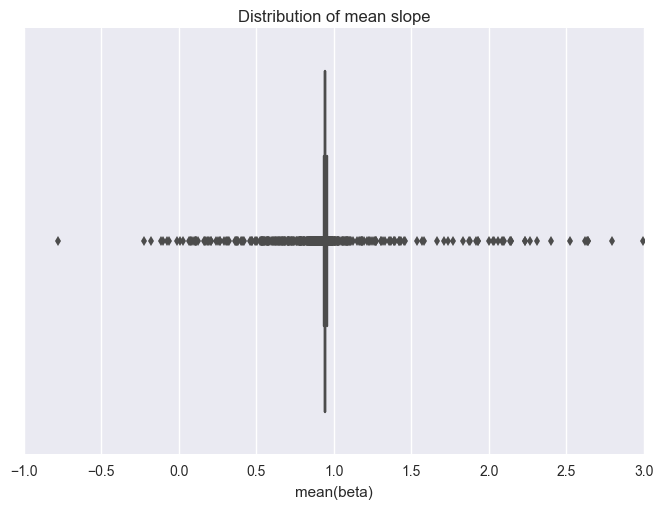

In [11]:
# Plot means distribution
g = sns.boxplot(beta_estimates)
g.set_title("Distribution of mean slope")
g.set_xlabel("mean(beta)");

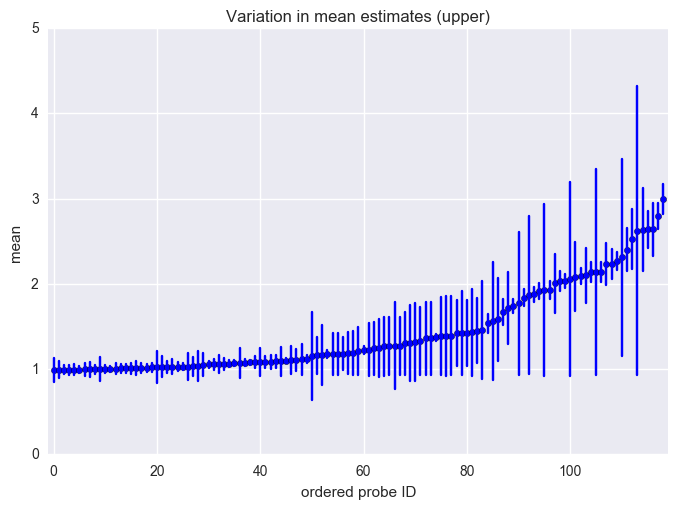

In [12]:
# errors for slope outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.99)

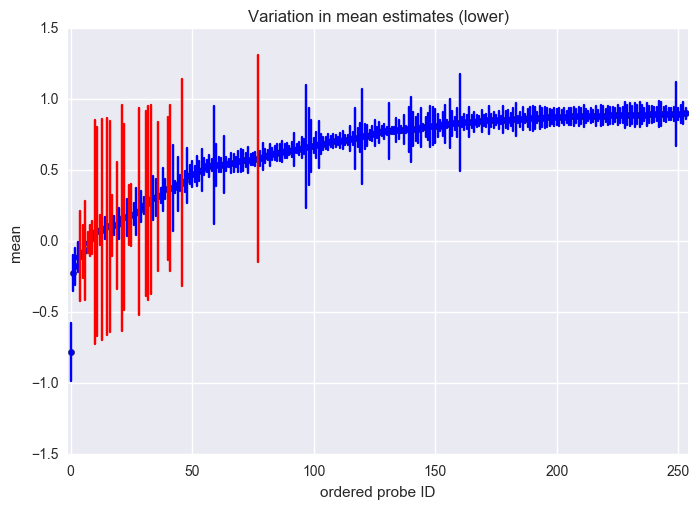

In [13]:
# errors for slope outliers
tools.plot_threshold_errors(beta_estimates, beta_se, 0.9, upper=False)

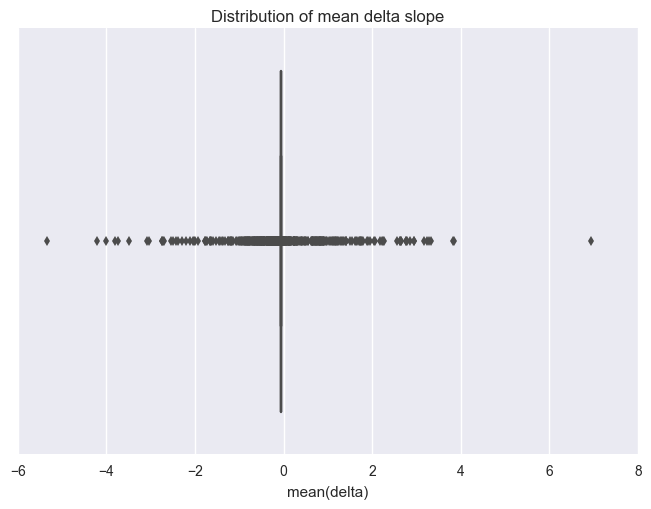

In [14]:
# Plot means distribution
g = sns.boxplot(delta_estimates)
g.set_title("Distribution of mean delta slope")
g.set_xlabel("mean(delta)");

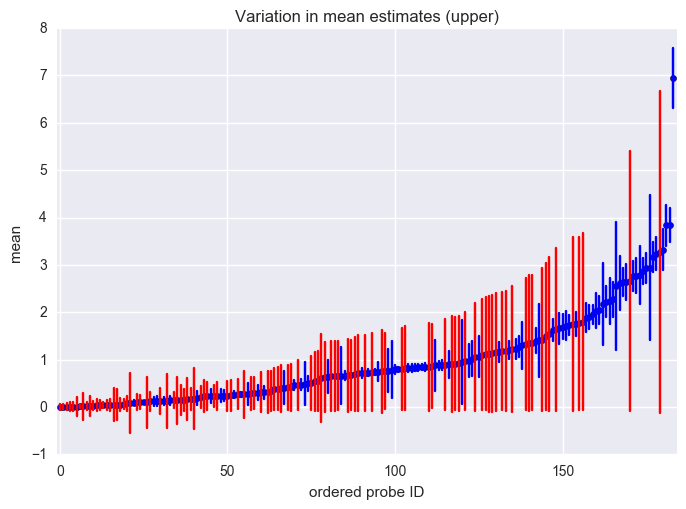

In [15]:
# errors for slope outliers
tools.plot_threshold_errors(delta_estimates, delta_se, 0)

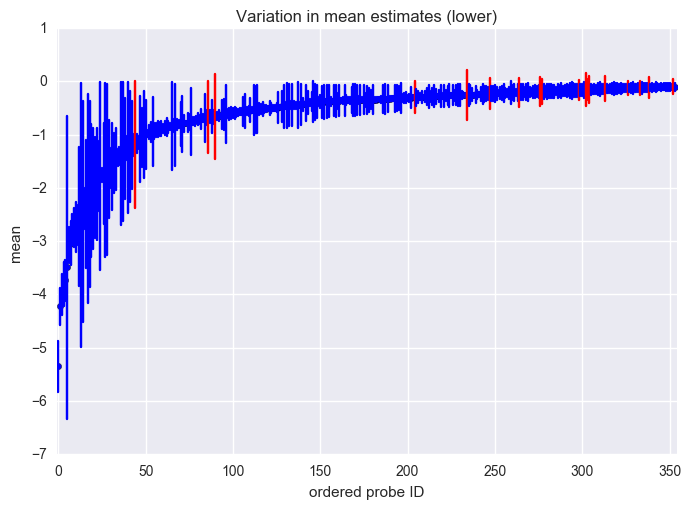

In [16]:
# errors for slope outliers
tools.plot_threshold_errors(delta_estimates, delta_se, -0.1, upper=False)

# Recovering predictions

In [17]:
# Get output log intensity estimates
#y_pred_estimates = pd.Series(prediction_fit['y_pred'].mean(0))
#y_pred_se = pd.Series(prediction_fit['y_pred'].std(0))

Exception: Data must be 1-dimensional

In [19]:
# Get output log intensity estimates
y_pred_estimates = pd.Series(prediction_fit['y_pred'][0].mean(0))
y_pred_se = pd.Series(prediction_fit['y_pred'][0].std(0))

In [20]:
test_data = test_data.reset_index(drop=True)
test_data['y_pred_mean'] = y_pred_estimates
test_data['y_pred_se'] = y_pred_se
test_data.sort_values('locus_tag', inplace=True)

In [21]:
test_data.head()

,dh10b_match,input,locus_tag,log_input,log_output,match,output,probe,replicate,sakai_match,treatment,probe_index,locus_index,y_pred_mean,y_pred_se
541,1.0,6026.244000,ECDH10B_RS00010,8.703879,8.527294,lcl|NC_010473.1_cds_WP_001264707.1_2,5050.760667,A_07_P010704,3,0,0,8059,8052,8.463282,0.371113
2945,1.0,3790.117000,ECDH10B_RS00015,8.240152,7.967212,lcl|NC_010473.1_cds_WP_000241662.1_3,2884.804000,A_07_P010710,3,1,0,5828,8046,8.034063,0.355712
4562,1.0,1117.641667,ECDH10B_RS00015,7.018976,6.759837,lcl|NC_010473.1_cds_WP_000241662.1_3,862.501833,A_07_P010710,3,1,1,5828,8046,6.875476,0.387377
2085,1.0,3162.275667,ECDH10B_RS00020,8.059047,7.769151,lcl|NC_010473.1_cds_WP_000781074.1_4,2366.462333,A_07_P010711,3,0,1,7741,7424,7.808636,0.379571
3052,1.0,10078.852667,ECDH10B_RS00020,9.218195,9.021965,lcl|NC_010473.1_cds_WP_000781074.1_4,8283.041000,A_07_P010711,3,0,0,7741,7424,8.960353,0.358814


(0, 7978)

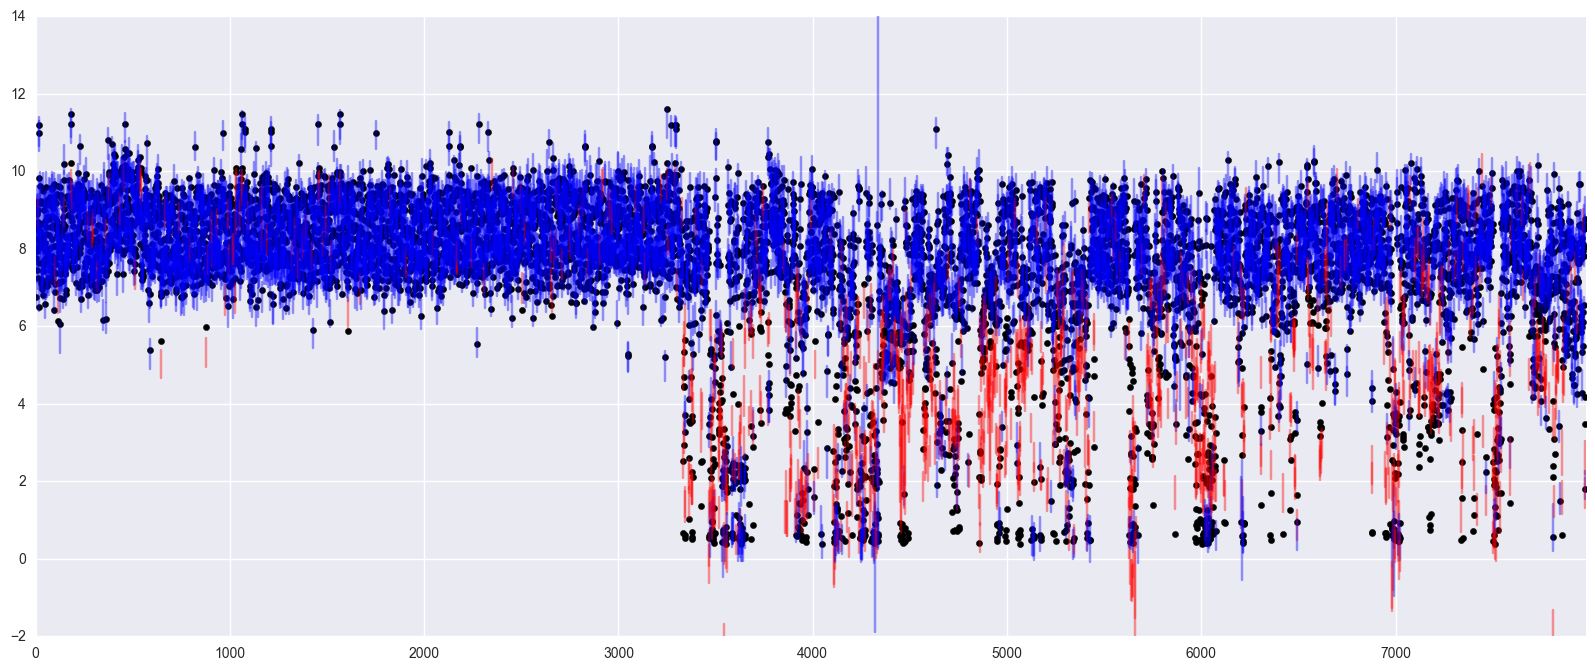

In [22]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
plt.scatter(range(len(test_data)), test_data['log_output'], alpha=1, color='k')
pos, neg = 0, 0
for idx, pmn, pse, mlo in zip(range(len(test_data)),
                              test_data['y_pred_mean'],
                              test_data['y_pred_se'],
                              test_data['log_output']):
    if pse > abs(pmn-mlo):
        pos += 1
        color = 'b-'
    else:
        neg += 1
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    plt.plot([idx, idx], [pmn - pse, pmn + pse], color, alpha=0.4)
plt.ylim(-2, 14)
plt.xlim(0, len(test_data))
#plt.xlim(800, 1000)

In [23]:
pos, neg, pos/(pos+neg), neg/(pos+neg)

(6748, 1230, 0.845826021559288, 0.15417397844071196)

In [24]:
beta_means = pd.DataFrame(beta_estimates)
beta_means.reset_index(inplace=True)
beta_means.columns = ['locus_tag', 'beta']
beta_means.head()

,locus_tag,beta
0,ECs1176,-0.011963
1,ECs2998,0.615439
2,ECs2997,0.865206
3,ECs2996,0.943045
4,ECs2993,0.945723


In [25]:
out = pd.merge(test_data, beta_means, 'inner', ['locus_tag'])

In [26]:
len(test_data), len(out['beta'])

(7978, 7978)

(0, 7978)

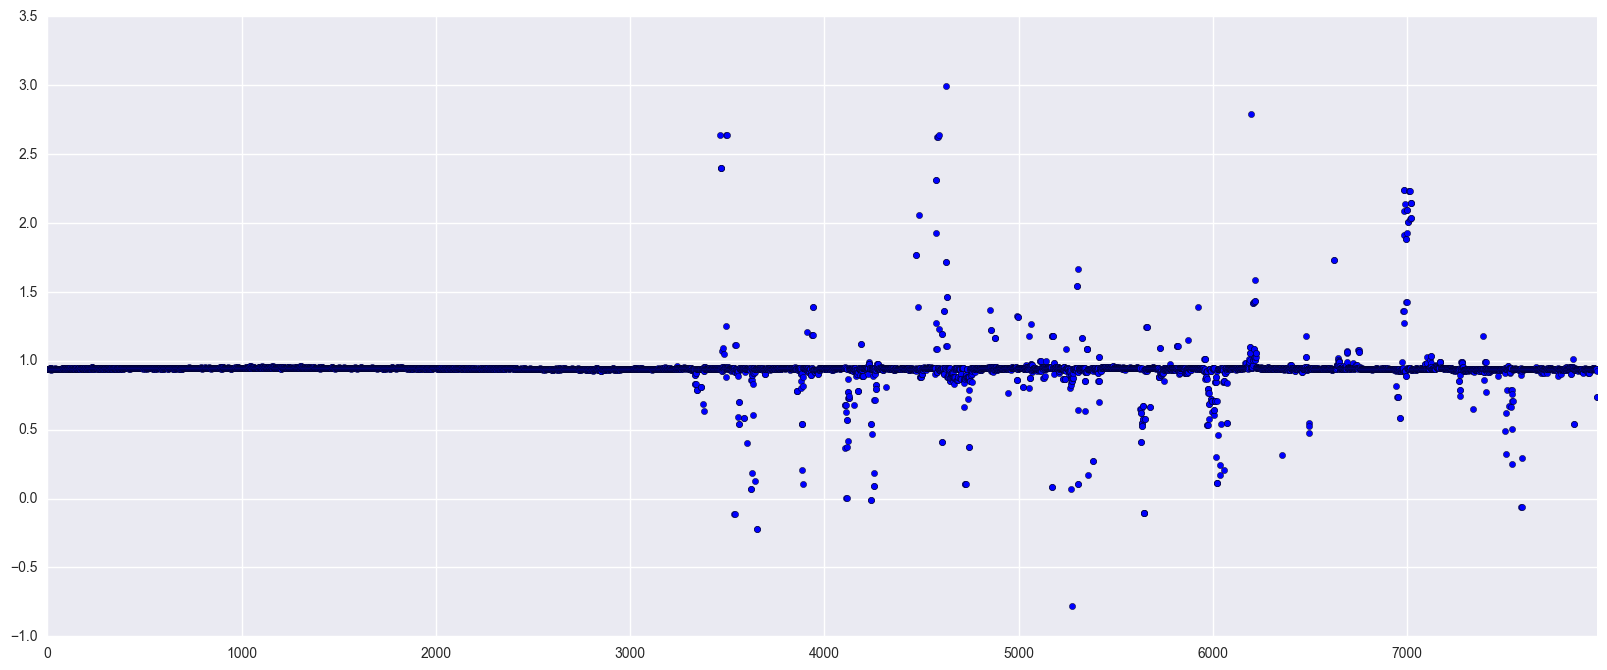

In [27]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
#plt.scatter(range(len(test_data)), test_data['beta'], alpha=1, color='k')
plt.scatter(range(len(test_data)), out['beta'])
for idx, pmn, pse, mlo in zip(range(len(out)),
                              out['y_pred_mean'],
                              out['y_pred_se'],
                              out['log_output']):
    if pse > abs(pmn-mlo):
        color = 'b-'
    else:
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    #plt.plot([idx, out['beta']])
plt.xlim(0, len(out))
#plt.xlim(800, 1000)
#plt.ylim(0.4, 1.2)

In [28]:
gamma_means = pd.DataFrame(gamma_estimates)
gamma_means.reset_index(inplace=True)
gamma_means.columns = ['locus_tag', 'gamma']
gamma_means.head()

,locus_tag,gamma
0,ECs1176,-1.372943
1,ECs2998,0.410979
2,ECs2997,0.434449
3,ECs2996,0.434080
4,ECs2993,0.414708


In [29]:
out = pd.merge(out, gamma_means, 'inner', ['locus_tag'])

(0, 7978)

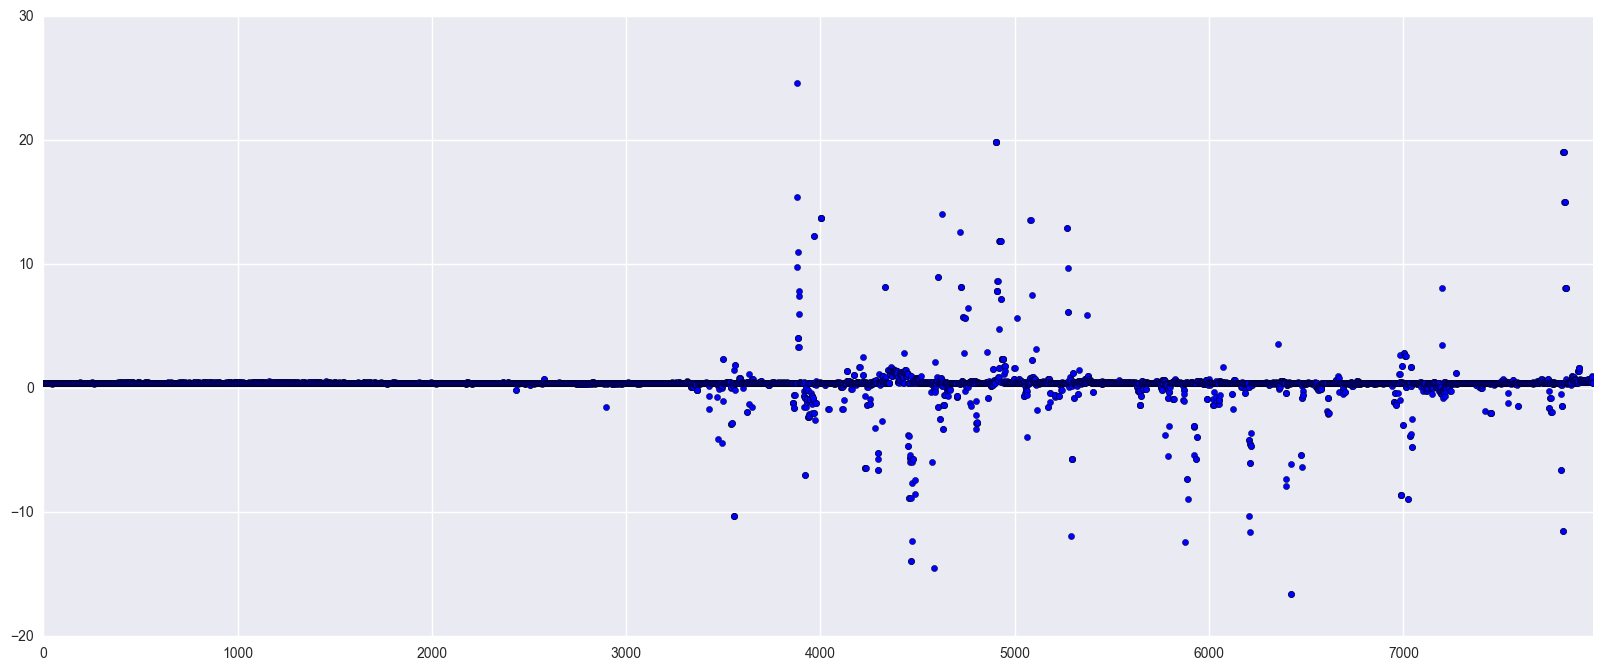

In [30]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
#plt.scatter(range(len(test_data)), test_data['beta'], alpha=1, color='k')
plt.scatter(range(len(test_data)), out['gamma'])
for idx, pmn, pse, mlo in zip(range(len(out)),
                              out['y_pred_mean'],
                              out['y_pred_se'],
                              out['log_output']):
    if pse > abs(pmn-mlo):
        color = 'b-'
    else:
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    #plt.plot([idx, out['beta']])
plt.xlim(0, len(out))
#plt.xlim(800, 1000)
#plt.ylim(0.1, 5)

In [31]:
alpha_means = pd.DataFrame(alpha_estimates)
alpha_means.reset_index(inplace=True)
alpha_means.columns = ['locus_tag', 'alpha']
out = pd.merge(out, alpha_means, 'inner', ['locus_tag'])
alpha_means.head()

,locus_tag,alpha
0,ECs1176,2.134186
1,ECs2998,0.329248
2,ECs2997,0.286493
3,ECs2996,0.276361
4,ECs2993,0.328393


(0, 7978)

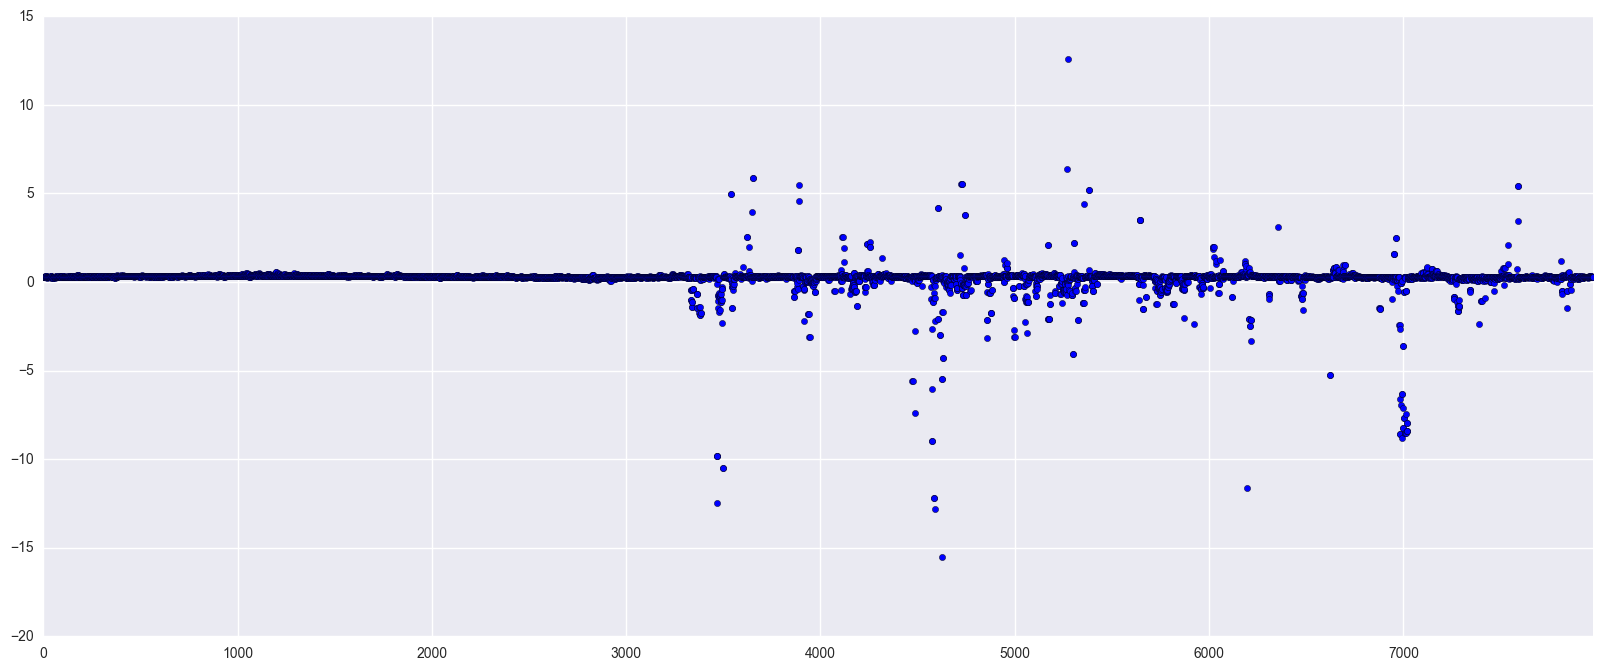

In [32]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
#plt.scatter(range(len(test_data)), test_data['beta'], alpha=1, color='k')
plt.scatter(range(len(test_data)), out['alpha'])
for idx, pmn, pse, mlo in zip(range(len(out)),
                              out['y_pred_mean'],
                              out['y_pred_se'],
                              out['log_output']):
    if pse > abs(pmn-mlo):
        color = 'b-'
    else:
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    #plt.plot([idx, out['beta']])
plt.xlim(0, len(out))
#plt.xlim(800, 1000)
#plt.ylim(0.1, 5)

In [33]:
delta_means = pd.DataFrame(delta_estimates)
delta_means.reset_index(inplace=True)
delta_means.columns = ['locus_tag', 'delta']
out = pd.merge(out, delta_means, 'inner', ['locus_tag'])
delta_means.head()

,locus_tag,delta
0,ECs1176,-0.062705
1,ECs2998,-0.515735
2,ECs2997,-0.707266
3,ECs2996,-0.858495
4,ECs2993,-0.067976


(0, 7978)

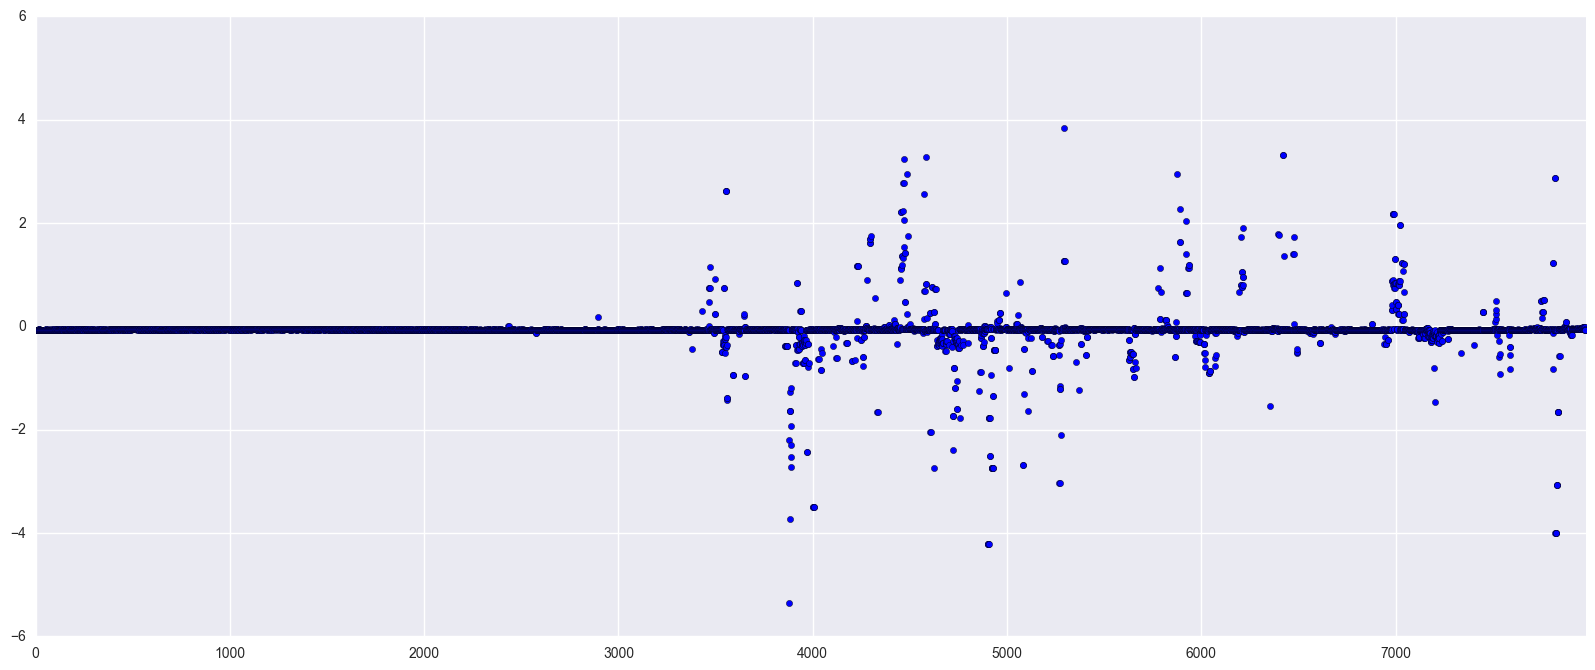

In [34]:
# plot ordered predictions and errors
plt.figure(figsize=(20,8))
#plt.scatter(range(len(test_data)), test_data['beta'], alpha=1, color='k')
plt.scatter(range(len(test_data)), out['delta'])
for idx, pmn, pse, mlo in zip(range(len(out)),
                              out['y_pred_mean'],
                              out['y_pred_se'],
                              out['log_output']):
    if pse > abs(pmn-mlo):
        color = 'b-'
    else:
        color = 'r-'
    #plt.plot([idx, idx], [mn - se, mn + se], color, alpha=0.4)
    #plt.plot([idx, out['beta']])
plt.xlim(0, len(out))
#plt.xlim(800, 1000)
#plt.ylim(0.1, 5)

In [35]:
delta_means = pd.DataFrame(delta_estimates)
delta_means.reset_index(inplace=True)
delta_means.columns = ['locus_tag', 'delta_mean']
delta_errors = pd.DataFrame(delta_se)
delta_errors.reset_index(inplace=True)
delta_errors.columns = ['locus_tag', 'delta_se']
deltas = pd.merge(delta_means, delta_errors, 'inner', ['locus_tag']).sort('locus_tag')
deltas.head()

,locus_tag,delta_mean,delta_se
8052,ECDH10B_RS00010,-0.064049,0.013020
8046,ECDH10B_RS00015,-0.065921,0.014235
7424,ECDH10B_RS00020,-0.063424,0.011538
5580,ECDH10B_RS00030,-0.063960,0.012298
8041,ECDH10B_RS00035,-0.064272,0.012697


(4300, 8532)

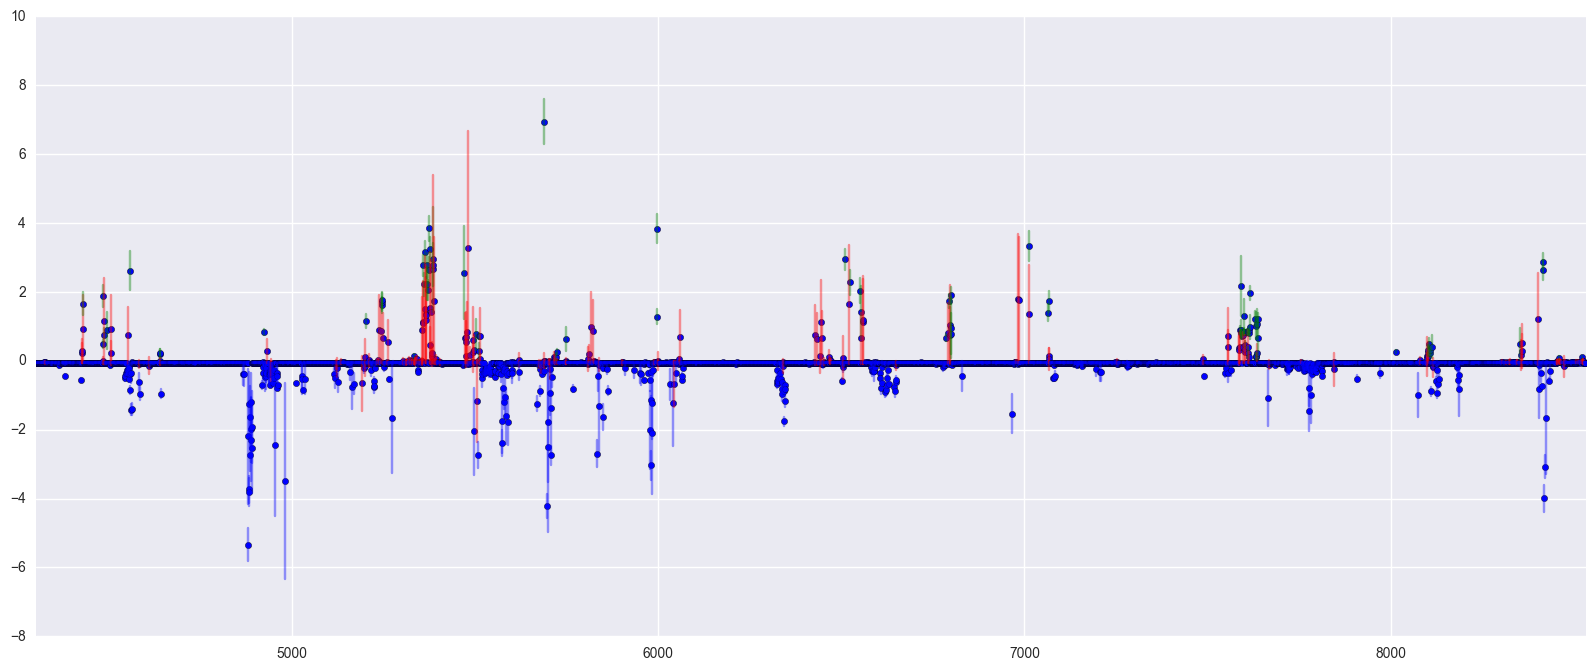

In [36]:
# plot predicted treatment effect
plt.figure(figsize=(20,8))
#plt.scatter(range(len(test_data)), test_data['beta'], alpha=1, color='k')
plt.scatter(range(len(deltas)), deltas['delta_mean'])
for idx, pmn, pse in zip(range(len(deltas)),
                              deltas['delta_mean'],
                              deltas['delta_se']):
    if abs(pmn) - abs(pse) > 0:
        color = 'b-'
        if pmn > 0:
            color = 'g-'
    else:
        color = 'r-'
    plt.plot([idx, idx], [pmn - pse, pmn + pse], color, alpha=0.4)
    #plt.plot([idx, out['beta']])
plt.xlim(4300, len(deltas))
#plt.xlim(4800, 5000)
#plt.ylim(0.4, 1.2)

In [37]:
# Identify significant delta locus tags
deltas['significant'] = abs(deltas['delta_mean']) - abs(deltas['delta_se']) > 0
significant = deltas.loc[deltas['significant']]

In [38]:
# Which locus tags have a significantly positive value of delta?
positives = significant.loc[significant['delta_mean'] > 0]
len(positives)

83

In [39]:
list(positives['locus_tag'])

['ECs0145',
 'ECs0212',
 'ECs0213',
 'ECs0216',
 'ECs0225',
 'ECs0304',
 'ECs0415',
 'ECs0416',
 'ECs0809',
 'ECs1172',
 'ECs1219',
 'ECs1220',
 'ECs1221',
 'ECs1321',
 'ECs1353',
 'ECs1354',
 'ECs1356',
 'ECs1365',
 'ECs1367',
 'ECs1370',
 'ECs1374',
 'ECs1375',
 'ECs1377',
 'ECs1387',
 'ECs1389',
 'ECs1506',
 'ECs1544',
 'ECs1556',
 'ECs1557',
 'ECs1780',
 'ECs1821',
 'ECs1825',
 'ECs1864',
 'ECs2192',
 'ECs2193',
 'ECs2847',
 'ECs2870',
 'ECs2908',
 'ECs2909',
 'ECs3222',
 'ECs3233',
 'ECs3239',
 'ECs3240',
 'ECs3241',
 'ECs3534',
 'ECs3608',
 'ECs3611',
 'ECs4327',
 'ECs4328',
 'ECs4329',
 'ECs4330',
 'ECs4331',
 'ECs4332',
 'ECs4334',
 'ECs4336',
 'ECs4337',
 'ECs4338',
 'ECs4340',
 'ECs4349',
 'ECs4351',
 'ECs4352',
 'ECs4353',
 'ECs4355',
 'ECs4356',
 'ECs4357',
 'ECs4379',
 'ECs4380',
 'ECs4381',
 'ECs4382',
 'ECs4384',
 'ECs4386',
 'ECs4387',
 'ECs4864',
 'ECs4972',
 'ECs4973',
 'ECs4975',
 'ECs4976',
 'ECs4982',
 'ECs5301',
 'ECs5414',
 'ECs5415',
 'pO157p08',
 'pO157p78']

In [40]:
prediction_fit.head()

,a,b,d,g,lp__,mu_a,mu_b,mu_d,mu_g,mu_pred,sigma_a,sigma_b,sigma_d,sigma_g,sigma_y,y_hat,y_pred
0,"[[2.08921134844, 0.404163602259, 0.06556205243...","[[-0.0061236722213, 0.497428596917, 0.91919106...","[[-0.0813618068685, -0.607317287917, -0.738678...","[[-1.23343050081, 0.414760053791, 0.3981010073...","[139647.759618, 140636.094425, 140229.720532, ...","[0.325659429413, 0.321403928335, 0.31527825057...","[0.94229768405, 0.942582194312, 0.942851490806...","[-0.0538893226835, -0.0539902385031, -0.053063...","[0.370821367837, 0.367176560049, 0.36525777130...","[[9.1576681527, 7.64946592414, 4.18941737657, ...","[0.0411201516531, 0.0367318550085, 0.037886170...","[0.00302733991233, 0.00307023365995, 0.0031450...","[0.00303245009412, 0.00295223645088, 0.0029580...","[0.026078733526, 0.0267946936852, 0.0275829883...","[0.36886785869, 0.368112765772, 0.367874577079...","[[2.07333981032, 2.07745912158, 2.05865599345,...","[[10.1021595618, 7.12274317061, 3.61523998087,..."


In [44]:
pd.Series(np.median(prediction_fit['y_pred'][0], 0))

0       9.126148
1       7.775003
2       4.332191
3       7.392421
4       9.104123
5       8.968378
6       6.084154
7       9.558876
8       9.030448
9       8.327550
10      7.783775
11      7.994385
12      8.093460
13      5.619959
14      6.508256
15      0.695928
16      5.320732
17      2.416510
18      2.327926
19      7.986426
20      7.904966
21      8.097373
22      2.853680
23      7.801570
24      8.468001
25      7.415396
26      8.652424
27      6.884223
28      9.525032
29      8.173834
          ...   
7948    7.625121
7949    7.112721
7950    7.504691
7951    8.374459
7952    9.266851
7953    8.905859
7954    4.092216
7955    8.347293
7956    9.261684
7957    9.386719
7958    9.910813
7959    2.190875
7960    8.455426
7961    3.482950
7962    9.240506
7963    9.015349
7964    7.900425
7965    8.548453
7966    4.553340
7967    4.952193
7968    9.368821
7969    8.748153
7970    2.241061
7971    7.807456
7972    9.385181
7973    4.893792
7974    3.772069
7975    4.5215

In [52]:
pd.Series(np.percentile(prediction_fit['y_pred'][0], 25, 0))

0       8.886909
1       7.525711
2       4.074610
3       7.138169
4       8.864843
5       8.714870
6       5.841047
7       9.331897
8       8.777731
9       8.055801
10      7.525927
11      7.749838
12      7.846143
13      5.342786
14      6.272797
15      0.402581
16      5.067912
17      2.149628
18      2.088342
19      7.731836
20      7.644813
21      7.849415
22      2.591328
23      7.530895
24      8.202082
25      7.156981
26      8.407793
27      6.614045
28      9.268611
29      7.906858
          ...   
7948    7.345365
7949    6.858248
7950    7.252302
7951    8.101266
7952    9.021927
7953    8.627597
7954    3.812001
7955    8.081626
7956    8.995421
7957    9.133165
7958    9.658289
7959    1.927645
7960    8.173718
7961    3.218990
7962    9.003030
7963    8.760683
7964    7.659295
7965    8.323644
7966    4.269155
7967    4.699920
7968    9.128198
7969    8.521033
7970    1.991127
7971    7.563976
7972    9.141441
7973    4.628188
7974    3.474070
7975    4.2761

In [51]:
help(np.percentile)

Help on function percentile in module numpy.lib.function_base:

percentile(a, q, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
    Compute the qth percentile of the data along the specified axis.
    
    Returns the qth percentile(s) of the array elements.
    
    Parameters
    ----------
    a : array_like
        Input array or object that can be converted to an array.
    q : float in range of [0,100] (or sequence of floats)
        Percentile to compute, which must be between 0 and 100 inclusive.
    axis : {int, sequence of int, None}, optional
        Axis or axes along which the percentiles are computed. The
        default is to compute the percentile(s) along a flattened
        version of the array. A sequence of axes is supported since
        version 1.9.0.
    out : ndarray, optional
        Alternative output array in which to place the result. It must
        have the same shape and buffer length as the expected output,
        bu

In [53]:
test_data.head()

,dh10b_match,input,locus_tag,log_input,log_output,match,output,probe,replicate,sakai_match,treatment,probe_index,locus_index,y_pred_mean,y_pred_se
541,1.0,6026.244000,ECDH10B_RS00010,8.703879,8.527294,lcl|NC_010473.1_cds_WP_001264707.1_2,5050.760667,A_07_P010704,3,0,0,8059,8052,8.463282,0.371113
2945,1.0,3790.117000,ECDH10B_RS00015,8.240152,7.967212,lcl|NC_010473.1_cds_WP_000241662.1_3,2884.804000,A_07_P010710,3,1,0,5828,8046,8.034063,0.355712
4562,1.0,1117.641667,ECDH10B_RS00015,7.018976,6.759837,lcl|NC_010473.1_cds_WP_000241662.1_3,862.501833,A_07_P010710,3,1,1,5828,8046,6.875476,0.387377
2085,1.0,3162.275667,ECDH10B_RS00020,8.059047,7.769151,lcl|NC_010473.1_cds_WP_000781074.1_4,2366.462333,A_07_P010711,3,0,1,7741,7424,7.808636,0.379571
3052,1.0,10078.852667,ECDH10B_RS00020,9.218195,9.021965,lcl|NC_010473.1_cds_WP_000781074.1_4,8283.041000,A_07_P010711,3,0,0,7741,7424,8.960353,0.358814
